<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 2: Practical - Support Vector Machines <br>
<font color=696880 size=4>
    Ali Shafiei (shafieiali42@gmail.com) <br>
    Ali Salmani (alisalmani200149@gmail.com)

____


### Full Name : Danial Ahangarani
### Student Number : 400211546
__

*It is highly recommended to read each codeline carefully and try to understand what it exactly does. Best of luck and have fun!*

# Support Vector Machines (SVM)

In [284]:
import warnings
warnings.filterwarnings('ignore')

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In this assignment, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

In [286]:
df = pd.read_csv("Liver_Disease.csv") 

In [287]:
df.head(3)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,label
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1


### Pre-Processing

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

In [289]:
##TODO: Find the shape of the dataset.
df_shape = df.shape
print(f'number of Rows: {df_shape[0]}\nnumber of Columns: {df_shape[1]}')

number of Rows: 583
number of Columns: 11


In [290]:
## TODO: Check if there is missing entries in the dataset columnwise.
missing_data_before = df.isnull().sum()
print('missing data before')
print(missing_data_before)
df['Albumin_and_Globulin_Ratio'].fillna(df['Albumin_and_Globulin_Ratio'].median(), inplace=True)
print("*********************************")
missing_data_after = df.isnull().sum()
print('missing data after')
print(missing_data_after)
print("*********************************")
print('missing entries replaced with median.')

missing data before
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64
*********************************
missing data after
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
label                         0
dtype: int64
*********************************
missing entries replaced with median.


In [291]:
## TODO: Check whether the dataset is balanced or not.
is_balanced = df['label'].value_counts()
print(is_balanced)
print('dataset is imbalanced.')

1    416
2    167
Name: label, dtype: int64
dataset is imbalanced.


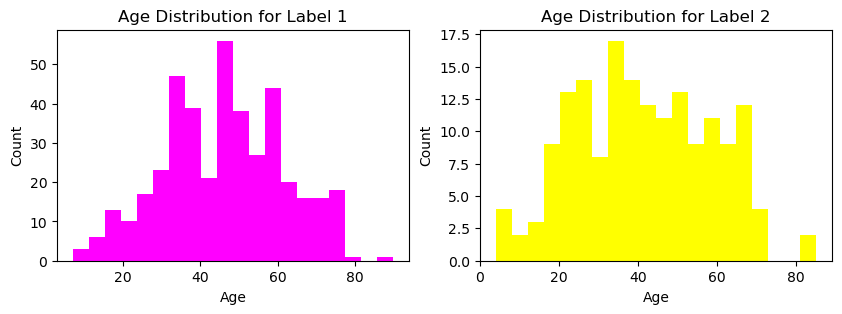

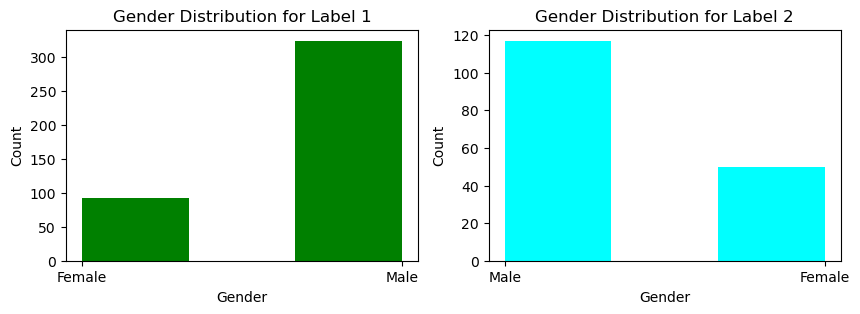

In [292]:
## TODO: plot the age distirbution and gender distrbution for both group    ##
## of patients.(4 plots)                                                    ##

df_label_1 = df[df['label'] == 1]
df_label_2 = df[df['label'] == 2]
# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].hist(df_label_1['Age'], bins=20, color='magenta')
axs[0].set_title('Age Distribution for Label 1')
axs[1].hist(df_label_2['Age'], bins=20, color='yellow')
axs[1].set_title('Age Distribution for Label 2')
for ax in axs.flat:
    ax.set(xlabel='Age', ylabel='Count')

# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].hist(df_label_1['Gender'], bins=3, color='green')
axs[0].set_title('Gender Distribution for Label 1')
axs[1].hist(df_label_2['Gender'], bins=3, color='cyan')
axs[1].set_title('Gender Distribution for Label 2')
for ax in axs.flat:
    ax.set(xlabel='Gender', ylabel='Count')

plt.show()

##### Question: What do you conclude from the plots?

We can infer from the gender distribution that the ratio of men to women in both classes is approximately three to one.

The age distribution in both classes is close to normal distribution.

#### Outlier Detection & Removal
Check whether we have outliers in the data. If there are, delete them.

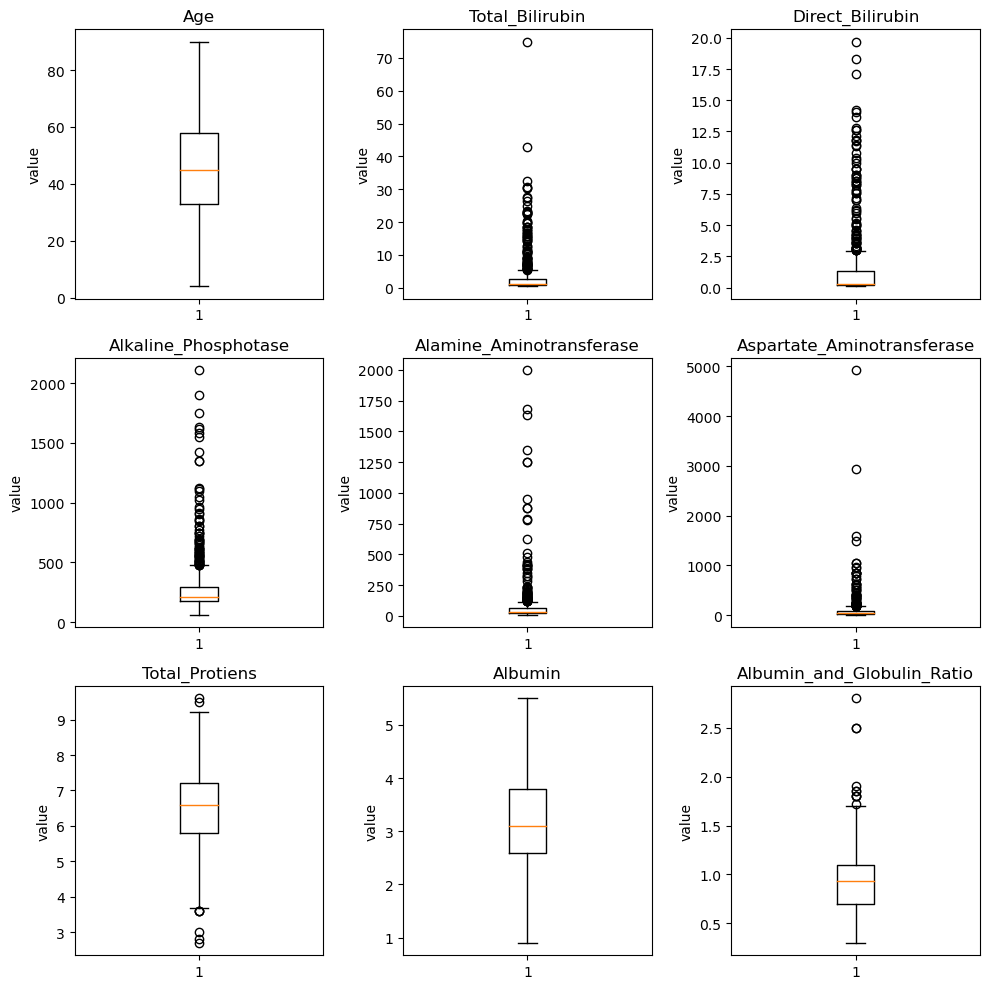

In [293]:
df_boxplot = df.drop(['Gender', 'label'], axis=1)
num_features = len(df_boxplot.columns)
rows = 3
cols = 3 

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))

for i, col in enumerate(df_boxplot.columns):
    row_idx = i // cols
    col_idx = i % cols    
    axs[row_idx, col_idx].boxplot(df_boxplot[col])
    axs[row_idx, col_idx].set_title(col)
    axs[row_idx, col_idx].set_ylabel('value')

plt.tight_layout()
plt.show()

We can see that some features, such as Total_Bilirubin and Direct_Bilirubin have outliers.

In [294]:
# The IQR for each column of the data frame, defines a lower and upper bound using the formula IQR ± 1.5 × IQR,
# and then removes any rows where at least one value falls outside this range.

# Select all columns except for the "gender" column
data_without_gender = df.loc[:, df.columns != 'Gender']

# Compute quartiles and IQR on the selected columns only
Q1 = data_without_gender.quantile(0.25)
Q3 = data_without_gender.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the selected columns only
clean_data = data_without_gender[(data_without_gender > lower_bound) & (data_without_gender < upper_bound)]
clean_data.dropna(inplace=True)

# Add the "gender" column back to the clean_data dataframe
clean_data = clean_data.join(df['Gender'])

#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.
also feel free to do more feature engineering techniques if needed.

In [295]:
## TODO: Normalize numerical features to be between 0 and 1

# extract the gender and label columns
gender = clean_data['Gender']
label = clean_data['label']

# extract the remaining columns
cols_to_normalize = list(clean_data.columns)
cols_to_normalize.remove('Gender')
cols_to_normalize.remove('label')

# normalize the data using MinMaxScaler
scaler = MinMaxScaler()
clean_data[cols_to_normalize] = scaler.fit_transform(clean_data[cols_to_normalize])

# merge the gender and label columns back with the normalized data
df_normalized = pd.concat([gender, clean_data[cols_to_normalize], label], axis=1)

In [296]:
def gender_to_numeric(gender):
    if gender == 'Male':
        return 0
    else:
        return 1
# Apply the function to the gender column using the map function
df_normalized['Gender'] = df_normalized['Gender'].map(gender_to_numeric)

### SVM

#### spliting data

In [297]:
## TODO Split the data into test and training sets.
from sklearn.model_selection import train_test_split
X = df_normalized.drop('label', axis=1)
y = df_normalized['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### SVM using Scikit-Learn:
First of all train an svm model with default parameters and report its.

In [298]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6125


#### Grid Search
Use Grid search and validation set to find the best parameters for your SVM model.

In [299]:
X_train_gs, X_val, y_train_gs, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Define the parameter grid to search over
param_grid = {'C': [.1,5,10,20], 'gamma': [.1,1,10,20], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4]}

# Create an SVM model object
svm_model = SVC()

# Perform Grid Search to find the best parameters for our model
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train_gs, y_train_gs)
best_params = grid_search.best_params_
# Print the best parameters found
print("Best Parameters: ", best_params)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print("Validation Set Accuracy: ", val_score)

Best Parameters:  {'C': 5, 'degree': 1, 'gamma': 20, 'kernel': 'rbf'}
Validation Set Accuracy:  0.671875


Train an svm model on the entire training data using the parameters you found in the previous step.

In [300]:
svm_model = SVC(**best_params)
svm_model.fit(X_train, y_train)

SVC(C=5, degree=1, gamma=20)

### Confusion Matrix
Plot the confusion matrix and report the model accuracy on test set.
What does each entry of the confusion matrix mean?

Model Accuracy:  0.7


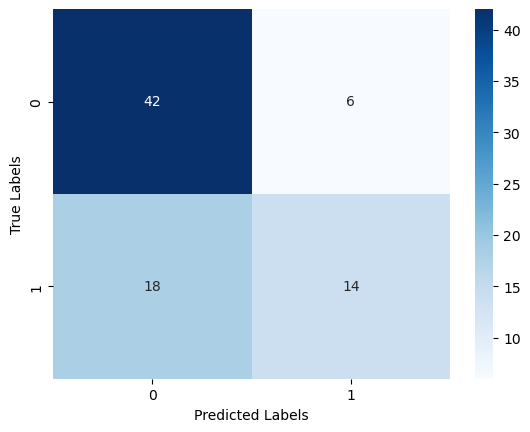

In [301]:
y_pred = svm_model.predict(X_test)

# Calculate the accuracy score of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: ", accuracy)

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [302]:
print('Results:')
print(classification_report(y_test, y_pred))

Results:
              precision    recall  f1-score   support

           1       0.70      0.88      0.78        48
           2       0.70      0.44      0.54        32

    accuracy                           0.70        80
   macro avg       0.70      0.66      0.66        80
weighted avg       0.70      0.70      0.68        80



Poor results on class 1 is because of less samples in this class

The four entries in a 2x2 confusion matrix represent:

True positive (TP): The number of instances that are actually positive and are correctly classified as positive by the model.

False positive (FP): The number of instances that are actually negative but are incorrectly classified as positive by the model.

True negative (TN): The number of instances that are actually negative and are correctly classified as negative by the model.

False negative (FN): The number of instances that are actually positive but are incorrectly classified as negative by the model.

Add some outliers to the dataset, train an SVM and logistic regression model, and compare the results.

In [303]:
# select 20 random instances and add outliers to two features
np.random.seed(42)
outlier_indices = np.random.choice(df_normalized.index, 20, replace=False)
df_normalized.loc[outlier_indices, 'Total_Bilirubin'] *= 10
df_normalized.loc[outlier_indices, 'Alkaline_Phosphotase'] *= 1000

# separate the features and target variable
X = df_normalized.drop(['label'], axis=1)
y = df_normalized['label']

In [304]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train SVM
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)
print('SVM results')
print(classification_report(y_test, y_pred))
print(f"SVM accuracy: {svm_acc:.4f}")
# train logistic regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
print('********************************************************')
print('Logistic Regression results')
print(classification_report(y_test, y_pred))
print(f"Logistic Regression accuracy: {lr_acc:.4f}")


SVM results
              precision    recall  f1-score   support

           1       0.70      0.75      0.72        56
           2       0.30      0.25      0.27        24

    accuracy                           0.60        80
   macro avg       0.50      0.50      0.50        80
weighted avg       0.58      0.60      0.59        80

SVM accuracy: 0.7125
********************************************************
Logistic Regression results
              precision    recall  f1-score   support

           1       0.70      0.75      0.72        56
           2       0.30      0.25      0.27        24

    accuracy                           0.60        80
   macro avg       0.50      0.50      0.50        80
weighted avg       0.58      0.60      0.59        80

Logistic Regression accuracy: 0.7375


It seems that both models have same results on this dataset.